In [1]:
from collections import defaultdict

import time 
import random
import numpy as np

import torch
import torch.nn as nn

In [2]:
gpu_id = "2"
device = torch.device("cuda:" + gpu_id if torch.cuda.is_available() else "cpu")

In [3]:
word2index = defaultdict(lambda : len(word2index))
tag2index = defaultdict(lambda : len(tag2index))

In [4]:
def read_data(data_path, sep):
    
    with open(data_path) as f:
        
        data = f.read().split("\n")
        
        for line in data:
            tmp = line.lower().strip().split(sep)
            
            if len(tmp) != 2:
                continue
            
            tag, sentence = tmp
            yield ([word2index[word] for word in sentence.split()], tag2index[tag])

In [5]:
train_data = list(read_data("../../cmu_data/classes/train.txt", " ||| "))
UNK = word2index["unk"]
word2index = defaultdict(lambda : UNK, word2index)
dev = list(read_data("../../cmu_data/classes/test.txt", " ||| "))
vocab_size = len(word2index)
tag_size = len(tag2index)

In [19]:
test_drop = nn.Dropout()
test_tmp = torch.randn(2, 3)

In [20]:
test_drop(test_tmp)

tensor([[ 3.3618, -0.5447,  1.3796],
        [ 0.0000,  1.4963, -0.0000]])

In [21]:
test_drop = nn.Dropout(1)
test_tmp = torch.randn(2, 3)

In [22]:
test_drop(test_tmp)

tensor([[0., -0., 0.],
        [0., 0., -0.]])

In [71]:
class AdvanceModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_size1, embedding_size2, tag_size):
        
        super(AdvanceModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size1)
        self.fc1 = nn.Linear(embedding_size1, embedding_size2)
        self.activation1 = nn.ReLU()
        self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(embedding_size2, tag_size)
    
    def forward(self, inputs):
        # inputs: (input_length, )
        
        inputs = self.embedding(inputs) # (input_length, embedding_size1)
        
        inputs = self.fc1(inputs) # (input_length, embedding_size2)
        inputs = self.dropout(inputs)
        inputs = self.activation1(inputs)
        
        inputs = torch.sum(inputs, dim=0, keepdim=True) # (1, embedding_size2)
        
        outputs = self.fc2(inputs) # (1, tag_size)
        
        return outputs

In [72]:
Embedding_size1, Embedding_size2 = 64, 64

In [73]:
net = AdvanceModel(vocab_size, Embedding_size1, Embedding_size2, tag_size).to(device)

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [75]:
loss_trace = []
acc_trace = []

In [76]:
train_tensor = [(torch.tensor(sent).to(device), torch.tensor([tag]).to(device)) for sent, tag in train_data]
dev_tensor = [(torch.tensor(sent).to(device), tag) for sent, tag in dev]

In [77]:
EPOCH = 50

for epoch in range(EPOCH):
    
    random.shuffle(train_tensor)
    
    start_time = time.time()
    train_loss = 0.0
    
    net.train()
    
    for sent, tag in train_tensor:
        
        
        output = net(sent)
        loss = criterion(output, tag)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_trace.append(train_loss / len(train_tensor))
    
    print("Epoch: {}, time: {}, loss: {}".format(epoch, time.time() - start_time, train_loss / len(train_tensor)))
    
    correct_num = 0
    
    with torch.no_grad():
        net.eval()
        
        for sent, tag in dev_tensor:
            
            output = net(sent)
            pred = torch.argmax(output, dim=1) # (1, )
            
            if pred[0] == tag:
                correct_num += 1
    
    acc_trace.append(correct_num / len(dev_tensor))
    print("Epoch: {}, acc: {}".format(epoch, correct_num / len(dev_tensor)))

Epoch: 0, time: 13.028997421264648, loss: 1.7022782320484575
Epoch: 0, acc: 0.3434389140271493
Epoch: 1, time: 11.055860996246338, loss: 1.4856566462582081
Epoch: 1, acc: 0.34434389140271493
Epoch: 2, time: 10.957271337509155, loss: 1.3610662461331722
Epoch: 2, acc: 0.38823529411764707
Epoch: 3, time: 14.936198234558105, loss: 1.2570562823658131
Epoch: 3, acc: 0.3760180995475113
Epoch: 4, time: 22.30114507675171, loss: 1.1555872045488755
Epoch: 4, acc: 0.3733031674208145
Epoch: 5, time: 23.79137945175171, loss: 1.0493458346734068
Epoch: 5, acc: 0.3904977375565611
Epoch: 6, time: 16.75532579421997, loss: 0.9648016182895861
Epoch: 6, acc: 0.37013574660633486
Epoch: 7, time: 24.51083993911743, loss: 0.8730994540049558
Epoch: 7, acc: 0.3751131221719457
Epoch: 8, time: 23.000749826431274, loss: 0.7946950390993588
Epoch: 8, acc: 0.37013574660633486
Epoch: 9, time: 22.63004994392395, loss: 0.7157773185847393
Epoch: 9, acc: 0.3565610859728507
Epoch: 10, time: 23.67009735107422, loss: 0.6660016

In [78]:
import matplotlib.pyplot as plt

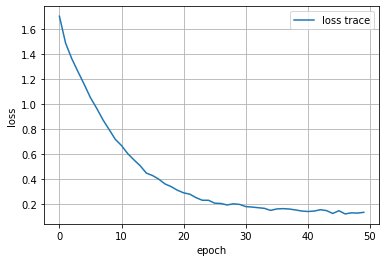

In [79]:
plt.plot(loss_trace, label="loss trace")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()

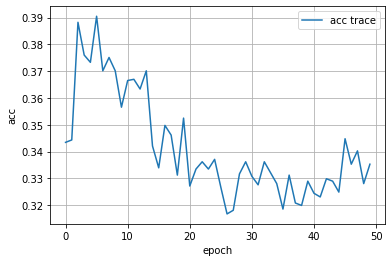

In [80]:
plt.plot(acc_trace, label="acc trace")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.grid()
plt.legend()

In [81]:
from torch.utils.tensorboard import SummaryWriter

In [82]:
writer = SummaryWriter("/data/rrjin/run/cmu_nlp_course/01-intro")

In [85]:
writer.add_graph(net, train_tensor[0][0])

In [86]:
writer.close()